# Определение стоимости автомобилей



Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные, нужно построить модель для определения стоимости. 
    
<b>Заказчику важны:</b>
    
- качество предсказания;
- скорость предсказания;
- время обучения.

<b>Признаки:</b>

- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя
    
<b>Целевой признак:</b>

- Price — цена (евро)



## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
pd.options.mode.chained_assignment = None
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor
import seaborn as sns

<div style="border-radius: 15px; border: 1px solid grey; padding: 15px;">
Загружаем данные.
</div>

In [2]:
df = pd.read_csv('/autos.csv')

<div style="border-radius: 15px; border: 1px solid grey; padding: 15px;">
Теперь проверим содержимое.
</div>

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


<div style="border-radius: 15px; border: 1px solid grey; padding: 15px;">
16 столбцов данных, присутствуют пропуски, но начнем с переименования признаков.
</div>

In [4]:
columns = df.columns.str.lower()

In [5]:
columns

Index(['datecrawled', 'price', 'vehicletype', 'registrationyear', 'gearbox',
       'power', 'model', 'kilometer', 'registrationmonth', 'fueltype', 'brand',
       'notrepaired', 'datecreated', 'numberofpictures', 'postalcode',
       'lastseen'],
      dtype='object')

In [6]:
columns = ['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type', 'brand',
       'not_repaired', 'date_created', 'number_of_pictures', 'postalcode',
       'last_seen']

In [7]:
df.columns = columns

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
date_crawled          354369 non-null object
price                 354369 non-null int64
vehicle_type          316879 non-null object
registration_year     354369 non-null int64
gearbox               334536 non-null object
power                 354369 non-null int64
model                 334664 non-null object
kilometer             354369 non-null int64
registration_month    354369 non-null int64
fuel_type             321474 non-null object
brand                 354369 non-null object
not_repaired          283215 non-null object
date_created          354369 non-null object
number_of_pictures    354369 non-null int64
postalcode            354369 non-null int64
last_seen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


<div style="border-radius: 15px; border: 1px solid grey; padding: 15px;">
Так то лучше, переходим непосредственно к работе с данными.
</div>

### Убираем лишние и не адекватные данные

<div style="border-radius: 15px; border: 1px solid grey; padding: 15px;">
Начнем с проверики чиловых признаков.
</div>

In [9]:
df.describe()

,price,registration_year,power,kilometer,registration_month,number_of_pictures,postalcode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


####  Признак количества фотографий и Дата скачивания анкеты из базы

<div style="border-radius: 15px; border: 1px solid grey; padding: 15px;">
Признак количества фотографий есть, а вот данных в столбце нет, столбец уберем, а в реальной задаче нужно проверить выгрузку данных. Нужно понять почему данных нет, так как эти данные действительно могут быть важным признаком.
</div>

In [10]:
df['number_of_pictures'].value_counts()

0    354369
Name: number_of_pictures, dtype: int64

<div style="border-radius: 15px; border: 1px solid grey; padding: 15px;">
Дата скачивания анкеты из базы 'date_crawled' не может быть признаком определяющим цену автомобиля, этот признак так же отбросим. 
</div>

In [11]:
df = df.drop(['date_crawled', 'number_of_pictures'], axis=1)

#### Целевой признак Цены

<div style="border-radius: 15px; border: 1px solid grey; padding: 15px;">
Пришло вермя целевого признака цены.
</div>

In [12]:
df['price'].value_counts().sort_index()

0        10772
1         1189
2           12
3            8
4            1
         ...  
19995       10
19997        1
19998        6
19999      278
20000      268
Name: price, Length: 3731, dtype: int64

In [13]:
df['price'].isna().sum()

0

<div style="border-radius: 15px; border: 1px solid grey; padding: 15px;">
Транспортное средство с ценой в 100 евро имеет место быть, но вот ТС с ценой ниже уже крайне мало вероятный сценарий, очень похоже на ошибку или на то, что цена намеренно скрывается продавцом. Отбросим строки цены в которых мене 100 евро, прогнозировать их не вижу смысла.
</div>

In [14]:
print('Количество строк с ценой ниже 100 евро:', df.loc[df['price'] < 100]['price'].count()) 

Количество строк с ценой ниже 100 евро: 13314


In [15]:
df = df.loc[df['price'] > 100]

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 340024 entries, 0 to 354368
Data columns (total 14 columns):
price                 340024 non-null int64
vehicle_type          307773 non-null object
registration_year     340024 non-null int64
gearbox               323939 non-null object
power                 340024 non-null int64
model                 323135 non-null object
kilometer             340024 non-null int64
registration_month    340024 non-null int64
fuel_type             312020 non-null object
brand                 340024 non-null object
not_repaired          276157 non-null object
date_created          340024 non-null object
postalcode            340024 non-null int64
last_seen             340024 non-null object
dtypes: int64(6), object(8)
memory usage: 38.9+ MB


#### Признак Год регистрации

In [17]:
df['registration_year'].value_counts()

2000    22496
1999    21780
2005    21341
2006    19639
2001    19550
        ...  
1931        1
1927        1
1925        1
3200        1
4100        1
Name: registration_year, Length: 136, dtype: int64

In [18]:
print('Количество строк с очевидно не корректным годом регисрации:',
      df.loc[(1900 < df['registration_year']) & (df['registration_year'] > 2021)]['registration_year'].count())

Количество строк с очевидно не корректным годом регисрации: 71


In [19]:
df = df.loc[(1900 < df['registration_year']) & (df['registration_year'] < 2021)]

In [20]:
df.describe()

,price,registration_year,power,kilometer,registration_month,postalcode
count,339913.000000,339913.000000,339913.000000,339913.000000,339913.000000,339913.000000
mean,4602.793244,2003.223860,111.588401,128539.626316,5.807607,50705.652517
std,4514.789534,7.305211,188.434592,37156.003020,3.685643,25721.592815
min,101.000000,1910.000000,0.000000,5000.000000,0.000000,1067.000000
25%,1200.000000,1999.000000,70.000000,125000.000000,3.000000,30455.000000
50%,2900.000000,2003.000000,105.000000,150000.000000,6.000000,49536.000000
75%,6500.000000,2008.000000,143.000000,150000.000000,9.000000,71229.000000
max,20000.000000,2019.000000,20000.000000,150000.000000,12.000000,99998.000000


#### Признак Месяц регистрации

In [21]:
df['registration_month'].value_counts()

3     33622
0     31094
6     30665
4     28510
5     28337
7     26525
10    25494
11    23657
12    23625
9     23256
1     22438
8     22006
2     20684
Name: registration_month, dtype: int64

<div style="border-radius: 15px; border: 1px solid grey; padding: 15px;">
Признаке месяца регистрации нет пропусков, но есть 13-ый месяц за порядковым номером 0, при том что 12-ый месяц так же присутсвует, и не дает нам воможности предположить, что номерация сдвинута на еденицу и начинается с 0. Удалить ~33 тысячи записей счтиаю расточительным, поэтому превратим пока 0 в пропуски, а потом заполним эти пропуски на соответствующем шаге.
</div>

In [22]:
df.loc[df['registration_month'] == 0, ['registration_month']] = np.nan

In [23]:
df['registration_month'].value_counts()

3.0     33622
6.0     30665
4.0     28510
5.0     28337
7.0     26525
10.0    25494
11.0    23657
12.0    23625
9.0     23256
1.0     22438
8.0     22006
2.0     20684
Name: registration_month, dtype: int64

### Заполнение пропусков

#### Заполнение признака Модель

<div style="border-radius: 15px; border: 1px solid grey; padding: 15px;">
Логика основанная на опыте подсказывает, что первыми по важности являются признаки марки и модели автомобиля. В марках пропусков нет, а вот в моделях пропуски присутствуют.
</div>

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 339913 entries, 0 to 354368
Data columns (total 14 columns):
price                 339913 non-null int64
vehicle_type          307773 non-null object
registration_year     339913 non-null int64
gearbox               323913 non-null object
power                 339913 non-null int64
model                 323071 non-null object
kilometer             339913 non-null int64
registration_month    308819 non-null float64
fuel_type             311989 non-null object
brand                 339913 non-null object
not_repaired          276138 non-null object
date_created          339913 non-null object
postalcode            339913 non-null int64
last_seen             339913 non-null object
dtypes: float64(1), int64(5), object(8)
memory usage: 38.9+ MB


<div style="border-radius: 15px; border: 1px solid grey; padding: 15px;">
В столбце модели ~17 тысяч пропусков, довольно много, даже для нашего датасета. Постараемся сохранить данные из этих строк. Для этого заполним пропуски. Для этого посмотрим насколько строко классифицированы автомобили. 
</div>

In [25]:
print(df.groupby(['brand', 'model', 'vehicle_type'])['model'].count().head(50))

brand       model   vehicle_type
alfa_romeo  145     coupe             2
                    other             1
                    sedan            12
                    small            19
            147     coupe            26
                    other             6
                    sedan           358
                    small            93
                    wagon             2
            156     coupe             3
                    other             1
                    sedan           265
                    small             2
                    wagon           281
            159     sedan            55
                    wagon           143
            other   convertible       1
                    coupe           178
                    other             4
                    sedan           179
                    small           114
                    wagon             6
            spider  convertible     176
                    coupe             1
audi   

<div style="border-radius: 15px; border: 1px solid grey; padding: 15px;">
По данным групировки видно , что в оригинальных данных нет строгой классификации, что кстати должно сказаться на качестве прогноза моделей, в действительности неплохо бы предпринять меры по улучшению ситуации с классификацией.
    
Для макимального приближеня к вероятным данным мы будем заполнять пропуски воспользовавшись групировкой по основным признакам. Для начала мы возьмем достаточно большое количество ключевых, на мой взгляд, признаков и заполним пропуски методом заполнения последним значением. Далее, по мере уменьшения количества оставшихся пропусков, мы будем делать групировку менее строгой и так заполним все пропуски. 
</div>

In [26]:
print('Пропусков первоначально:', df['model'].isna().sum())
df['model'] = df.groupby(['brand', 'vehicle_type', 'registration_year', 'fuel_type', 'gearbox', 'price'])['model'].ffill()
df['model'] = df.groupby(['brand', 'vehicle_type', 'registration_year', 'fuel_type', 'gearbox', 'price'])['model'].bfill()
print('Пропусков после 1 шага:', df['model'].isna().sum())

df['model'] = df.groupby(['brand', 'vehicle_type', 'registration_year', 'fuel_type', 'gearbox'])['model'].ffill()
df['model'] = df.groupby(['brand', 'vehicle_type', 'registration_year', 'fuel_type', 'gearbox'])['model'].bfill()
print('Пропусков после 2 шага:', df['model'].isna().sum())

df['model'] = df.groupby(['brand', 'vehicle_type', 'registration_year', 'fuel_type'])['model'].ffill()
df['model'] = df.groupby(['brand', 'vehicle_type', 'registration_year', 'fuel_type'])['model'].bfill()
print('Пропусков после 3 шага:', df['model'].isna().sum())

df['model'] = df.groupby(['brand', 'vehicle_type', 'registration_year'])['model'].ffill()
df['model'] = df.groupby(['brand', 'vehicle_type', 'registration_year'])['model'].bfill()
print('Пропусков после 4 шага:', df['model'].isna().sum())

df['model'] = df.groupby(['brand', 'vehicle_type'])['model'].ffill()
df['model'] = df.groupby(['brand', 'vehicle_type'])['model'].bfill()
print('Пропусков после 5 шага:', df['model'].isna().sum())

Пропусков первоначально: 16842
Пропусков после 1 шага: 4790
Пропусков после 2 шага: 2079
Пропусков после 3 шага: 1740
Пропусков после 4 шага: 911
Пропусков после 5 шага: 0


<div style="border-radius: 15px; border: 1px solid grey; padding: 15px;">
Пропуски заполнены. Так же можно обратить внимание, что был добавлен метод заполнения значением следующим за пропусками, так как в групировке пропуски оказывались в первой строке, но при этом они попадали по критериям в группу и заполнение их значением из этой группы считаю даиболее логичным.
</div>

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 339913 entries, 0 to 354368
Data columns (total 14 columns):
price                 339913 non-null int64
vehicle_type          307773 non-null object
registration_year     339913 non-null int64
gearbox               323913 non-null object
power                 339913 non-null int64
model                 339913 non-null object
kilometer             339913 non-null int64
registration_month    308819 non-null float64
fuel_type             311989 non-null object
brand                 339913 non-null object
not_repaired          276138 non-null object
date_created          339913 non-null object
postalcode            339913 non-null int64
last_seen             339913 non-null object
dtypes: float64(1), int64(5), object(8)
memory usage: 38.9+ MB


#### Заполнение признака Тип кузова

In [28]:
df['vehicle_type'].value_counts()

sedan          88965
small          77029
wagon          63384
bus            28256
convertible    19807
coupe          15534
suv            11758
other           3040
Name: vehicle_type, dtype: int64

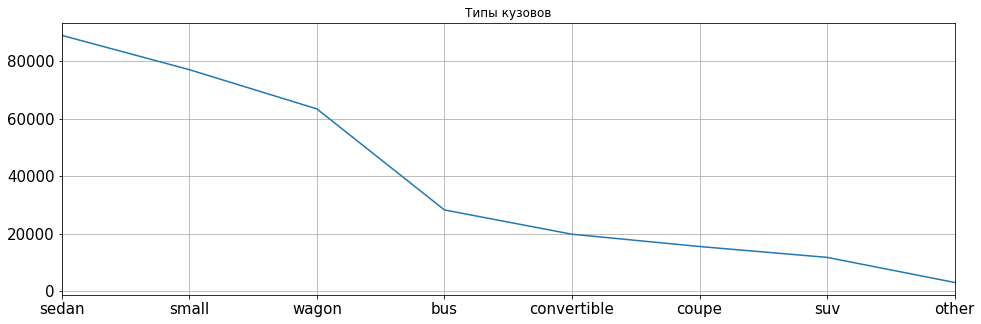

In [29]:
df['vehicle_type'].value_counts().plot(kind='line',
        title='Типы кузовов',
        grid=True,
        figsize=(16,5),
        fontsize=15, 
        )

In [30]:
df['vehicle_type'].isna().sum()

32140

<div style="border-radius: 15px; border: 1px solid grey; padding: 15px;">
Опять большое колличество пропусков, будем заполнять. Тип кузова с большой вероятностью востанавливается по марке и модели автомобиля. Воспользуемся методом из предыдущего шага и заполним сгрупировав по марке и модели автомобиля. Приведена кривая распределения по типам кузовов, проверим её же полсле заполнения пропусков.
</div>

In [31]:
print('Пропусков первоначально:', df['vehicle_type'].isna().sum())
df['vehicle_type'] = df.groupby(['brand', 'model'])['vehicle_type'].ffill()
df['vehicle_type'] = df.groupby(['brand', 'model'])['vehicle_type'].bfill()
print('Пропусков после 1 шага:', df['vehicle_type'].isna().sum())

df['vehicle_type'] = df.groupby(['model'])['vehicle_type'].ffill()
print('Пропусков после 2 шага:', df['vehicle_type'].isna().sum())

Пропусков первоначально: 32140
Пропусков после 1 шага: 1117
Пропусков после 2 шага: 0


In [32]:
df['vehicle_type'].value_counts()

sedan          98076
small          86726
wagon          68777
bus            31696
convertible    21496
coupe          17061
suv            12534
other           3547
Name: vehicle_type, dtype: int64

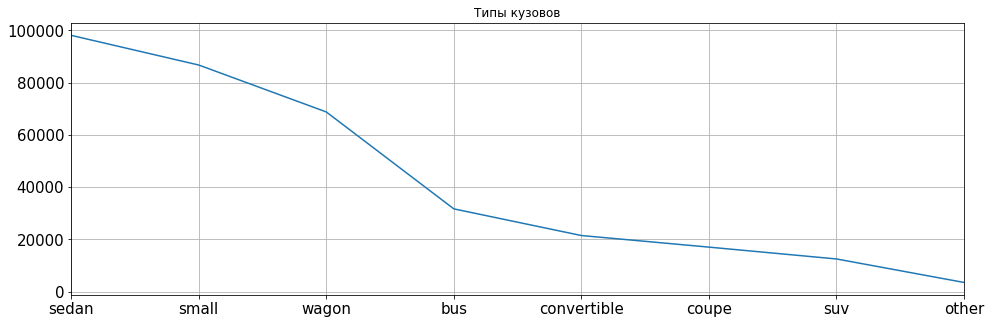

In [33]:
df['vehicle_type'].value_counts().plot(kind='line',
        title='Типы кузовов',
        grid=True,
        figsize=(16,5),
        fontsize=15, 
        )

<div style="border-radius: 15px; border: 1px solid grey; padding: 15px;">
Пропуски заполнены, соотношение сохранено - выбросов не появилось.
</div>

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 339913 entries, 0 to 354368
Data columns (total 14 columns):
price                 339913 non-null int64
vehicle_type          339913 non-null object
registration_year     339913 non-null int64
gearbox               323913 non-null object
power                 339913 non-null int64
model                 339913 non-null object
kilometer             339913 non-null int64
registration_month    308819 non-null float64
fuel_type             311989 non-null object
brand                 339913 non-null object
not_repaired          276138 non-null object
date_created          339913 non-null object
postalcode            339913 non-null int64
last_seen             339913 non-null object
dtypes: float64(1), int64(5), object(8)
memory usage: 38.9+ MB


#### Заполнение признака Коробка передачь

<div style="border-radius: 15px; border: 1px solid grey; padding: 15px;">
Аналогичным образом поступим с пропусками в признаке коробки передачь.
</div>

In [35]:
print('Пропусков первоначально:', df['gearbox'].isna().sum())
df['gearbox'] = df.groupby(['brand', 'model', 'power', 'fuel_type'])['gearbox'].ffill()
df['gearbox'] = df.groupby(['brand', 'model', 'power', 'fuel_type'])['gearbox'].bfill()
print('Пропусков после 1 шага:', df['gearbox'].isna().sum())

df['gearbox'] = df.groupby(['brand', 'model', 'power'])['gearbox'].ffill()
df['gearbox'] = df.groupby(['brand', 'model', 'power'])['gearbox'].bfill()
print('Пропусков после 2 шага:', df['gearbox'].isna().sum())

df['gearbox'] = df.groupby(['brand', 'model'])['gearbox'].ffill()
df['gearbox'] = df.groupby(['brand', 'model'])['gearbox'].bfill()
print('Пропусков после 3 шага:', df['gearbox'].isna().sum())

df['gearbox'] = df.groupby(['model'])['gearbox'].ffill()
print('Пропусков после 4 шага:', df['gearbox'].isna().sum())

Пропусков первоначально: 16000
Пропусков после 1 шага: 851
Пропусков после 2 шага: 539
Пропусков после 3 шага: 137
Пропусков после 4 шага: 0


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 339913 entries, 0 to 354368
Data columns (total 14 columns):
price                 339913 non-null int64
vehicle_type          339913 non-null object
registration_year     339913 non-null int64
gearbox               339913 non-null object
power                 339913 non-null int64
model                 339913 non-null object
kilometer             339913 non-null int64
registration_month    308819 non-null float64
fuel_type             311989 non-null object
brand                 339913 non-null object
not_repaired          276138 non-null object
date_created          339913 non-null object
postalcode            339913 non-null int64
last_seen             339913 non-null object
dtypes: float64(1), int64(5), object(8)
memory usage: 38.9+ MB


####  Заполнение признака Тип топлива

<div style="border-radius: 15px; border: 1px solid grey; padding: 15px;">
Тип топлива будем заполнять базируясь на Марке, Модели и Мощьности автомобиля.
</div>

In [37]:
print('Пропусков первоначально:', df['fuel_type'].isna().sum())
df['fuel_type'] = df.groupby(['brand', 'model', 'power'])['fuel_type'].ffill()
df['fuel_type'] = df.groupby(['brand', 'model', 'power'])['fuel_type'].bfill()
print('Пропусков после 1 шага:', df['fuel_type'].isna().sum())

df['fuel_type'] = df.groupby(['brand', 'model'])['fuel_type'].ffill()
df['fuel_type'] = df.groupby(['brand', 'model'])['fuel_type'].bfill()
print('Пропусков после 2 шага:', df['fuel_type'].isna().sum())

df['fuel_type'] = df.groupby(['model'])['fuel_type'].ffill()
print('Пропусков после 3 шага:', df['fuel_type'].isna().sum())

Пропусков первоначально: 27924
Пропусков после 1 шага: 3589
Пропусков после 2 шага: 1195
Пропусков после 3 шага: 0


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 339913 entries, 0 to 354368
Data columns (total 14 columns):
price                 339913 non-null int64
vehicle_type          339913 non-null object
registration_year     339913 non-null int64
gearbox               339913 non-null object
power                 339913 non-null int64
model                 339913 non-null object
kilometer             339913 non-null int64
registration_month    308819 non-null float64
fuel_type             339913 non-null object
brand                 339913 non-null object
not_repaired          276138 non-null object
date_created          339913 non-null object
postalcode            339913 non-null int64
last_seen             339913 non-null object
dtypes: float64(1), int64(5), object(8)
memory usage: 38.9+ MB


#### Заполнение признака Не ремонтировалась

In [39]:
df['not_repaired'].isna().sum()

63775

In [40]:
df['not_repaired'].value_counts()

no     243052
yes     33086
Name: not_repaired, dtype: int64

In [41]:
print('Доля отремонтированных:', 
      df.loc[df['not_repaired'] == 'yes']['not_repaired'].count() / df.loc[df['not_repaired'] == 'no']['not_repaired'].count())

Доля отремонтированных: 0.13612724849003505


<div style="border-radius: 15px; border: 1px solid grey; padding: 15px;">
Перед заполнением пропусков посчитали долю отремонтированных автомобилей в имеющихся данных. Заполнять будем на основе данных о годе регистрации и пробеге.
</div>

In [42]:
print('Доля пропусков в признаке Не ремонтировалась', df['not_repaired'].isna().sum() / len(df))

Доля пропусков в признаке Не ремонтировалась 0.18762153845248636


In [43]:
print('Пропусков первоначально:', df['not_repaired'].isna().sum())
df['not_repaired'] = df.groupby(['registration_year'])['not_repaired'].ffill()
df['not_repaired'] = df.groupby(['registration_year'])['not_repaired'].bfill()
print('Пропусков после 1 шага:', df['not_repaired'].isna().sum())

df['not_repaired'] = df.groupby(['kilometer'])['not_repaired'].ffill()
df['not_repaired'] = df.groupby(['kilometer'])['not_repaired'].bfill()
print('Пропусков после 2 шага:', df['not_repaired'].isna().sum())

Пропусков первоначально: 63775
Пропусков после 1 шага: 5
Пропусков после 2 шага: 0


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 339913 entries, 0 to 354368
Data columns (total 14 columns):
price                 339913 non-null int64
vehicle_type          339913 non-null object
registration_year     339913 non-null int64
gearbox               339913 non-null object
power                 339913 non-null int64
model                 339913 non-null object
kilometer             339913 non-null int64
registration_month    308819 non-null float64
fuel_type             339913 non-null object
brand                 339913 non-null object
not_repaired          339913 non-null object
date_created          339913 non-null object
postalcode            339913 non-null int64
last_seen             339913 non-null object
dtypes: float64(1), int64(5), object(8)
memory usage: 38.9+ MB


In [45]:
df['not_repaired'].value_counts()

no     297268
yes     42645
Name: not_repaired, dtype: int64

In [46]:
print('Доля отремонтиованных:', 
      df.loc[df['not_repaired'] == 'yes']['not_repaired'].count() / df.loc[df['not_repaired'] == 'no']['not_repaired'].count())

Доля отремонтиованных: 0.1434564097043745


<div style="border-radius: 15px; border: 1px solid grey; padding: 15px;">
Доля после заполнения изменилась мене чем на процент, при том что заполнено было почти 19 процентов данных. Не идельно, но близко.
</div>

#### Заполнение признака Месяц регистрации

<div style="border-radius: 15px; border: 1px solid grey; padding: 15px;">
Возваращаемся к ранее удаленным 0 в признаке месяц регистрации. ЗАполним обычным переносом последнего значения.
</div>

In [47]:
df['registration_month'] = df['registration_month'].ffill()
df['registration_month'] = df['registration_month'].bfill()

In [48]:
df['registration_month'].value_counts()

3.0     37074
6.0     33732
4.0     31329
5.0     31064
7.0     29259
10.0    28030
11.0    26086
12.0    25942
9.0     25592
1.0     24797
8.0     24244
2.0     22764
Name: registration_month, dtype: int64

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 339913 entries, 0 to 354368
Data columns (total 14 columns):
price                 339913 non-null int64
vehicle_type          339913 non-null object
registration_year     339913 non-null int64
gearbox               339913 non-null object
power                 339913 non-null int64
model                 339913 non-null object
kilometer             339913 non-null int64
registration_month    339913 non-null float64
fuel_type             339913 non-null object
brand                 339913 non-null object
not_repaired          339913 non-null object
date_created          339913 non-null object
postalcode            339913 non-null int64
last_seen             339913 non-null object
dtypes: float64(1), int64(5), object(8)
memory usage: 38.9+ MB


<div style="border-radius: 15px; border: 1px solid grey; padding: 15px;">
Эффект получен, данные заполнены, выбросов не появилось.
    
Все пропуски заполнены, теперь переходим к преобразованию данных, что бы наши модели могли работать с данными.
</div>

### Преобразование

#### Преобразование Года регистрации

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 339913 entries, 0 to 354368
Data columns (total 14 columns):
price                 339913 non-null int64
vehicle_type          339913 non-null object
registration_year     339913 non-null int64
gearbox               339913 non-null object
power                 339913 non-null int64
model                 339913 non-null object
kilometer             339913 non-null int64
registration_month    339913 non-null float64
fuel_type             339913 non-null object
brand                 339913 non-null object
not_repaired          339913 non-null object
date_created          339913 non-null object
postalcode            339913 non-null int64
last_seen             339913 non-null object
dtypes: float64(1), int64(5), object(8)
memory usage: 38.9+ MB


In [51]:
df['registration_year'].head()

0    1993
1    2011
2    2004
3    2001
4    2008
Name: registration_year, dtype: int64

<div style="border-radius: 15px; border: 1px solid grey; padding: 15px;">
На текущий момент год регистрации имеет целочисленный вид, но в целом год это категориальная переменная, поэтому преобразуем значения в строки для дальнейшего перекодирования категориальной переменной методом One Hot Encoding.
</div>

In [52]:
df['registration_year'] = df['registration_year'].astype(str)

In [53]:
df['registration_year']

0         1993
1         2011
2         2004
3         2001
4         2008
          ... 
354363    2000
354365    2005
354366    2000
354367    1996
354368    2002
Name: registration_year, Length: 339913, dtype: object

#### Преобразование Месяца регистрации

<div style="border-radius: 15px; border: 1px solid grey; padding: 15px;">
Таким же образом поступим с месяцем регистрации.
</div>

In [54]:
df['registration_month'].head()

0    5.0
1    5.0
2    8.0
3    6.0
4    7.0
Name: registration_month, dtype: float64

In [55]:
df['registration_month'] = df['registration_month'].astype(int).astype(str)

In [56]:
df['registration_month']

0         5
1         5
2         8
3         6
4         7
         ..
354363    3
354365    1
354366    3
354367    3
354368    6
Name: registration_month, Length: 339913, dtype: object

#### Преобразование Даты создания

<div style="border-radius: 15px; border: 1px solid grey; padding: 15px;">
С датой создания нельзя поступить так же как с датой регистрации, так как дат слишком много и категорий получится неоправдано много. Поэтому преобразуем текущий строковый вормат в формат даты\времени, а уже из него преобразуем данные в Unix время. 
</div>

In [57]:
df['date_created'].value_counts()

2016-04-03 00:00:00    13233
2016-04-04 00:00:00    12783
2016-03-12 00:00:00    12386
2016-03-20 00:00:00    12367
2016-03-21 00:00:00    12154
                       ...  
2015-03-20 00:00:00        1
2016-01-06 00:00:00        1
2015-09-09 00:00:00        1
2016-01-08 00:00:00        1
2015-12-17 00:00:00        1
Name: date_created, Length: 109, dtype: int64

In [58]:
df['date_created'] = pd.to_datetime(df['date_created'], format='%Y-%m-%d')

In [59]:
df['date_created'] = df['date_created'].astype(np.int64)

In [60]:
df['date_created'].head()

0    1458777600000000000
1    1458777600000000000
2    1457913600000000000
3    1458172800000000000
4    1459382400000000000
Name: date_created, dtype: int64

#### Преобразование Даты последней активности

<div style="border-radius: 15px; border: 1px solid grey; padding: 15px;">
Аналогичным способом преобразуем дату последеней активности в Unix формат
</div>

In [61]:
df['last_seen'].head()

0    2016-04-07 03:16:57
1    2016-04-07 01:46:50
2    2016-04-05 12:47:46
3    2016-03-17 17:40:17
4    2016-04-06 10:17:21
Name: last_seen, dtype: object

In [62]:
df['last_seen'] = pd.to_datetime(df['last_seen'], format='%Y-%m-%d %H:%M:%S')

In [63]:
df['last_seen'] = df['last_seen'].astype(np.int64)

In [64]:
df['last_seen']

0         1459999017000000000
1         1459993610000000000
2         1459860466000000000
3         1458236417000000000
4         1459937841000000000
                 ...         
354363    1459246643000000000
354365    1459903612000000000
354366    1457720232000000000
354367    1460013326000000000
354368    1458823521000000000
Name: last_seen, Length: 339913, dtype: int64

#### Кодирование One Hot Encoding

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 339913 entries, 0 to 354368
Data columns (total 14 columns):
price                 339913 non-null int64
vehicle_type          339913 non-null object
registration_year     339913 non-null object
gearbox               339913 non-null object
power                 339913 non-null int64
model                 339913 non-null object
kilometer             339913 non-null int64
registration_month    339913 non-null object
fuel_type             339913 non-null object
brand                 339913 non-null object
not_repaired          339913 non-null object
date_created          339913 non-null int64
postalcode            339913 non-null int64
last_seen             339913 non-null int64
dtypes: int64(6), object(8)
memory usage: 38.9+ MB


<div style="border-radius: 15px; border: 1px solid grey; padding: 15px;">
Приведем потенциальное количество категорий в наших категориальных переменных, так же посмотрим на значения почтового индекса, может ли он быть категорией.
</div>

In [66]:
df['vehicle_type'].value_counts().count()

8

In [67]:
df['gearbox'].value_counts().count()

2

In [68]:
df['model'].value_counts().count()

250

In [69]:
df['fuel_type'].value_counts().count()

7

In [70]:
df['brand'].value_counts().count()

40

In [71]:
df['not_repaired'].value_counts().count()

2

In [72]:
df['registration_month'].value_counts().count()

12

In [73]:
df['registration_year'].value_counts().count()

95

In [74]:
df['postalcode'].value_counts().count()

8137

<div style="border-radius: 15px; border: 1px solid grey; padding: 15px;">
Почтовй индекс сделать категориальной переменной делать не целесообразно, опять же, данные вероятно синтетические, так как такое разнообразие идексов и их форматов вызывает вопросы. Эти вопросы стоит задать коллегам которые могут объяснить происхождение данных.
</div>

<div style="border-radius: 15px; border: 1px solid grey; padding: 15px;">
Воспользуемся функцией get_dummies для кодирования наших признаков.
</div>

In [75]:
df = pd.get_dummies(df, drop_first=True)

In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 339913 entries, 0 to 354368
Columns: 414 entries, price to not_repaired_yes
dtypes: int64(6), uint8(408)
memory usage: 150.4 MB


<div style="border-radius: 15px; border: 1px solid grey; padding: 15px;">
Количество признаков значительно увеличилось, что было ожидаемо.
</div>

#### Разбиение на подвыборик

<div style="border-radius: 15px; border: 1px solid grey; padding: 15px;">
Перед нормализацией цифровых переменных разобьем наш сет на подвыборки: Обучающую, Валидационную и Тестовую.
</div>

In [77]:
df_train_valid, df_test = train_test_split(df, test_size=0.2, random_state=12345)
df_train, df_valid = train_test_split(df_train_valid, test_size=0.25, random_state=12345)

In [78]:
df_train.head()

,price,power,kilometer,date_created,postalcode,last_seen,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,...,brand_skoda,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,not_repaired_yes
166897,3250,110,150000,1459036800000000000,25337,1459383511000000000,0,0,0,1,...,0,0,0,0,0,0,0,1,0,1
30149,7800,200,150000,1457481600000000000,24558,1458546627000000000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
308063,7800,70,100000,1457740800000000000,52134,1458517477000000000,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
227309,11111,163,150000,1457481600000000000,40625,1459818992000000000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
346727,500,116,150000,1459468800000000000,45257,1459582953000000000,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


<div style="border-radius: 15px; border: 1px solid grey; padding: 15px;">
Разделим признаки и целевой признак Цены
</div>

In [79]:
features_train = df_train.drop(['price'], axis=1)
target_train = df_train['price']

In [80]:
features_valid = df_valid.drop(['price'], axis=1)
target_valid = df_valid['price']

In [81]:
features_test = df_test.drop(['price'], axis=1)
target_test = df_test['price']

In [82]:
features_train.shape

(203947, 413)

<div style="border-radius: 15px; border: 1px solid grey; padding: 15px;">
Готово, можно переходить к нормализации данных в признаках.
</div>

#### Нормализация 

<div style="border-radius: 15px; border: 1px solid grey; padding: 15px;">
Выделим цифровые признаки и произведем скалирование соответствующей функцией.
</div>

In [83]:
numeric = ['postalcode', 'kilometer', 'power', 'date_created', 'last_seen']

In [84]:
scaler = StandardScaler()
scaler.fit(features_train[numeric]) 

StandardScaler(copy=True, with_mean=True, with_std=True)

In [85]:
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric]) 

In [86]:
features_train.head()

,power,kilometer,date_created,postalcode,last_seen,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,...,brand_skoda,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,not_repaired_yes
166897,-0.010646,0.578160,0.658288,-0.987850,0.103674,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,1
30149,0.429859,0.578160,-1.255726,-1.018151,-0.954480,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
308063,-0.206426,-0.768482,-0.936724,0.054480,-0.991337,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
227309,0.248763,0.578160,-1.255726,-0.393189,0.654294,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
346727,0.018721,0.578160,1.189959,-0.213017,0.355848,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


<div style="border-radius: 15px; border: 1px solid grey; padding: 15px;">
Результат на шаге выше, а мы можем переходить к обучению моделей, данные готовы.
</div>

## Обучение моделей

<div style="border-radius: 15px; border: 1px solid grey; padding: 15px;">
Метрикой с котрой мы будем работать будет RMSE (root-mean-square error) корень из средне квадратичной ошибки. Метрика будет прямо в евро показывать на сколько мы в среднем далеки от правильных ответов при прогнозировании. А начнем мы с расчета RMSE для предсказания в котором все значения будут средним цены автомобилей. Именно ориентируясь на эту цифру мы можем понять адекватна наша модель или среднее число прогнозирует лучше и наша модел ни куда не годится.
</div>

In [87]:
dummy_regressor_rougher = DummyRegressor(strategy="mean")
dummy_regressor_rougher.fit(features_train, target_train)
dummy_rougher_pred = dummy_regressor_rougher.predict(features_test)
rmse = mean_squared_error(target_valid, dummy_rougher_pred) ** 0.5
print('RMSE при заполнении предсказания средним значением целевого признака: ', rmse)

RMSE при заполнении предсказания средним значением целевого признака:  4509.490851629796


<div style="border-radius: 15px; border: 1px solid grey; padding: 15px;">
Если модель покажет RMSE ниже 4500 евро, то это уже прогресс.
</div>

### DecisionTreeRegressor

<div style="border-radius: 15px; border: 1px solid grey; padding: 15px;">
Первой моделью возьмем Дерево решений.
</div>

In [88]:
#for i in range(1, 23):
#    dt_model = DecisionTreeRegressor(random_state = 12345, max_depth = i)
#    dt_model.fit(features_train, target_train)
#    dt_prediction = dt_model.predict(features_valid)
#    dt_rmse = mean_squared_error(target_valid, dt_prediction) ** 0.5
#    print(' Максимальная глубина =', i, '\n', 'RMSE', dt_rmse, '\n') 

<div style="border-radius: 15px; border: 1px solid grey; padding: 15px;">
Выше в ячейке закоменчек код релизующий поиск оптимальной глубины дерева, исходя из результатов выбрана глубина 15 уровней.
</div>

In [89]:
dt_model = DecisionTreeRegressor(max_depth=15, presort=True, random_state = 12345)

In [90]:
%%time
dt_model.fit(features_train, target_train)

CPU times: user 1min 52s, sys: 557 ms, total: 1min 53s
Wall time: 1min 53s


DecisionTreeRegressor(criterion='mse', max_depth=15, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=True, random_state=12345, splitter='best')

In [91]:
%%time
dt_prediction = dt_model.predict(features_valid)

CPU times: user 92.7 ms, sys: 75.7 ms, total: 168 ms
Wall time: 174 ms


In [92]:
dt_rmse = mean_squared_error(target_valid, dt_prediction) ** 0.5

In [93]:
print('RMSE для модели Решающего дерева на Валидационной выборке:', dt_rmse)

RMSE для модели Решающего дерева на Валидационной выборке: 2196.276360978482


<div style="border-radius: 15px; border: 1px solid grey; padding: 15px;">
Проверим на тестовой выборке.
</div>

In [94]:
%%time
dt_prediction_test = dt_model.predict(features_test)

CPU times: user 62 ms, sys: 104 ms, total: 166 ms
Wall time: 168 ms


In [95]:
dt_rmse_test = mean_squared_error(target_test, dt_prediction_test) ** 0.5

In [96]:
print('RMSE для модели Решающего дерева на Тестовой выборке:', dt_rmse_test)

RMSE для модели Решающего дерева на Тестовой выборке: 2177.868964336849


<div style="border-radius: 15px; border: 1px solid grey; padding: 15px;">
Да, тестовая выборка сформирована из тех же данных, показатели RMSE очень близки.
    
Фиксируем RMSE 2178 евро, время предсказания ~180мс. 
</div>

### RandomForestRegressor

<div style="border-radius: 15px; border: 1px solid grey; padding: 15px;">
Следующая в нашем исследовании модель Случайного леса, действовать будем аналогично предыдущему шагу.
</div>

In [97]:
#%%time
#rf_best_model = None
#rf_rmse_best = 10000000
#rf_best_depth = 0
#rf_best_est = 0
#for est in range(90, 91, 10):
#    for depth in range(14, 17, 1):
#        rf_model = RandomForestRegressor(n_estimators=est, max_depth=depth, random_state=12345)
#        rf_model.fit(features_train, target_train)
#        rf_prediction = rf_model.predict(features_valid)
#        rf_rmse = mean_squared_error(target_valid, rf_prediction) ** 0.5
#        if rf_rmse < rf_rmse_best:
#            rf_best_model = rf_model
#            rf_rmse_best = rf_rmse
#            rf_best_depth = depth
#            rf_best_est = est
        

#print(' RMSE =', rf_rmse_best, '\n', 'Количество деревьев =', rf_best_est, '\n',
#      "Максимальная глубина:", rf_best_depth) 

<div style="border-radius: 15px; border: 1px solid grey; padding: 15px;">
Выше код с поиском оптимальных гипер параметров. Переходим к обучению и тестированию.
</div>

In [98]:
rf_model = RandomForestRegressor(n_estimators=90, max_depth=15, random_state=12345)

In [99]:
%%time 
rf_model.fit(features_train, target_train)

CPU times: user 8min 29s, sys: 578 ms, total: 8min 29s
Wall time: 8min 29s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=90,
                      n_jobs=None, oob_score=False, random_state=12345,
                      verbose=0, warm_start=False)

In [100]:
%%time
rf_prediction = rf_model.predict(features_valid)

CPU times: user 1.08 s, sys: 79.9 ms, total: 1.16 s
Wall time: 1.17 s


In [101]:
rf_rmse = mean_squared_error(target_valid, rf_prediction) ** 0.5

In [102]:
print('RMSE для модели Случайного на Валидационной выборке:', rf_rmse)

RMSE для модели Случайного на Валидационной выборке: 1995.9244192166877


<div style="border-radius: 15px; border: 1px solid grey; padding: 15px;">
Проверка на тестовой выборке.
</div>

In [103]:
%%time
rf_prediction = rf_model.predict(features_test)

CPU times: user 1.05 s, sys: 87.9 ms, total: 1.14 s
Wall time: 1.14 s


In [104]:
rf_rmse = mean_squared_error(target_test, rf_prediction) ** 0.5

In [105]:
print('RMSE для модели Случайного на Тестовой выборке:', rf_rmse)

RMSE для модели Случайного на Тестовой выборке: 1998.030117425941


<div style="border-radius: 15px; border: 1px solid grey; padding: 15px;">
Прогресс в точности предсказания очевиден, но и время предсказания вырасло более чем в 7 раз.

Фиксируем RMSE 1998 евро, время предсказания ~1.5 с.
</div>

### LightGBM Regressor

<div style="border-radius: 15px; border: 1px solid grey; padding: 15px;">
Переходим к градиентному бустингу с использованием LightGBM, создадим словарь параметров, создадим модель и обучим её.
</div>

In [106]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'max_depth': 16,
    'metric': 'rmse',
    'learning_rate': 0.05,
    "n_estimators": 1000
}

In [107]:
gb_model = lgb.LGBMRegressor(**params)

In [108]:
%%time
gb_model.fit(features_train, target_train, eval_set=[(features_valid, target_valid)], early_stopping_rounds=10)

[1]	valid_0's rmse: 4375.76
Training until validation scores don't improve for 10 rounds
[2]	valid_0's rmse: 4252.68
[3]	valid_0's rmse: 4136.8
[4]	valid_0's rmse: 4031.32
[5]	valid_0's rmse: 3929.36
[6]	valid_0's rmse: 3836.05
[7]	valid_0's rmse: 3747.32
[8]	valid_0's rmse: 3664.99
[9]	valid_0's rmse: 3586.97
[10]	valid_0's rmse: 3512.34
[11]	valid_0's rmse: 3444.84
[12]	valid_0's rmse: 3381.07
[13]	valid_0's rmse: 3317.69
[14]	valid_0's rmse: 3259.3
[15]	valid_0's rmse: 3202.56
[16]	valid_0's rmse: 3146.29
[17]	valid_0's rmse: 3094.03
[18]	valid_0's rmse: 3046.7
[19]	valid_0's rmse: 3005.6
[20]	valid_0's rmse: 2963.74
[21]	valid_0's rmse: 2923.91
[22]	valid_0's rmse: 2885.78
[23]	valid_0's rmse: 2847.72
[24]	valid_0's rmse: 2813.02
[25]	valid_0's rmse: 2779.3
[26]	valid_0's rmse: 2747.87
[27]	valid_0's rmse: 2714.94
[28]	valid_0's rmse: 2688.45
[29]	valid_0's rmse: 2665.53
[30]	valid_0's rmse: 2633.42
[31]	valid_0's rmse: 2607.88
[32]	valid_0's rmse: 2586.85
[33]	valid_0's rmse: 2558

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.05, max_depth=16,
              metric='rmse', min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=1000, n_jobs=-1, num_leaves=31,
              objective='regression', random_state=None, reg_alpha=0.0,
              reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

<div style="border-radius: 15px; border: 1px solid grey; padding: 15px;">
Обучили модель, теперь проверим время предсказания и результат метрики RMSE на тестовой выборке.
</div>

In [109]:
%%time
gb_model_pred = gb_model.predict(features_test, num_iteration=gb_model.best_iteration_)

CPU times: user 8.26 s, sys: 157 ms, total: 8.42 s
Wall time: 8.99 s


In [110]:
gb_rmse = mean_squared_error(target_test, gb_model_pred) ** 0.5

In [111]:
gb_rmse

1651.6839844320848

<div style="border-radius: 15px; border: 1px solid grey; padding: 15px;">
Прогресс в точности предсказания опять очевиден, но вот время предсказания вырасло драматически.

Фиксируем RMSE 1652 евро, время предсказания ~9,5 с.
</div>

## Анализ моделей

<div style="border-radius: 15px; border: 1px solid grey; padding: 15px;">
У нас есть результаты по трем моделям, визуализируем их, добавих так же отношение RMSE для трех наших моделей.
</div>

In [112]:
results = {'RMSE': [dt_rmse, rf_rmse, gb_rmse],
           'Prediction_Time': [0.18, 1.5, 9.5],
           'Training_Time': [1.12, 5.07, 1.54]}
df_results = pd.DataFrame(data=results, index=['DT', 'RF', 'GB'])
df_results['Ratio'] = df_results['RMSE'] / dt_rmse * 10
df_results

,RMSE,Prediction_Time,Training_Time,Ratio
DT,2196.276361,0.18,1.12,10.000000
RF,1998.030117,1.50,5.07,9.097353
GB,1651.683984,9.50,1.54,7.520383


Text(0, 0.5, 'Показатели')

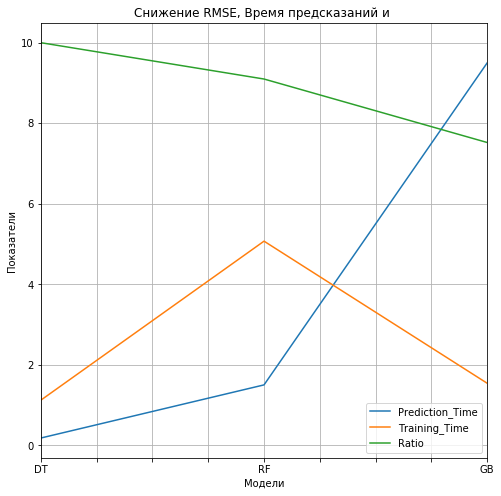

In [113]:
df_results[['Prediction_Time', 'Training_Time', 'Ratio']].plot(kind='line',
        title='Снижение RMSE, Время предсказаний и ',
        grid=True,
        figsize=(8,8),
        fontsize=10
        )

plt.xlabel('Модели')
plt.ylabel("Показатели")

<div style="border-radius: 15px; border: 1px solid grey; padding: 15px;">
        В столбец Ratio помещены расчеты на сколько уменьшился показатель RMSE отностительно самой слабой модели Дерева решений. Эти два графика и представлены выше, в показателе Retio убран 0, для наглядности.
    
Так же масштабированы данные времени обучения для наглядности на одной системе координат. Первоначально замеры взяты в секундах, а записаны на два разряда меньше.  
</div>

<div style="border-radius: 15px; border: 1px solid grey; padding: 15px;">
<b> Итог:</b>
    
Лучший показатель RMSE меньше худшего на 25%, тогда как время предсказания вырасло более чем на 5000%. Не сложно сделать вывод, что в зависимости от выбраных приоритетов на скорость предсказания или на точность, можно выбирать между применением этих моделей. Если крайне важна скорость предсказания, можно пожертвовать тосчностью и использовать Дерево решений, а если исключить фактор времени предсказания, то однозначным выбором будет Градиентный Бустинг. Так же LightGBM показывает отличный результат по времени обучения и, принимая во внимание качество прогноза, по этому параметру градиентный бустинг однозначный лидер в нашем исследовании.
    
PS    
Посмотрим на веса признаков.

</div>

In [114]:
def plotImp(model, X , num = 20, fig_size = (40, 20)):
    feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':X.columns})
    plt.figure(figsize=fig_size)
    sns.set(font_scale = 5)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances-01.png')
    plt.show()

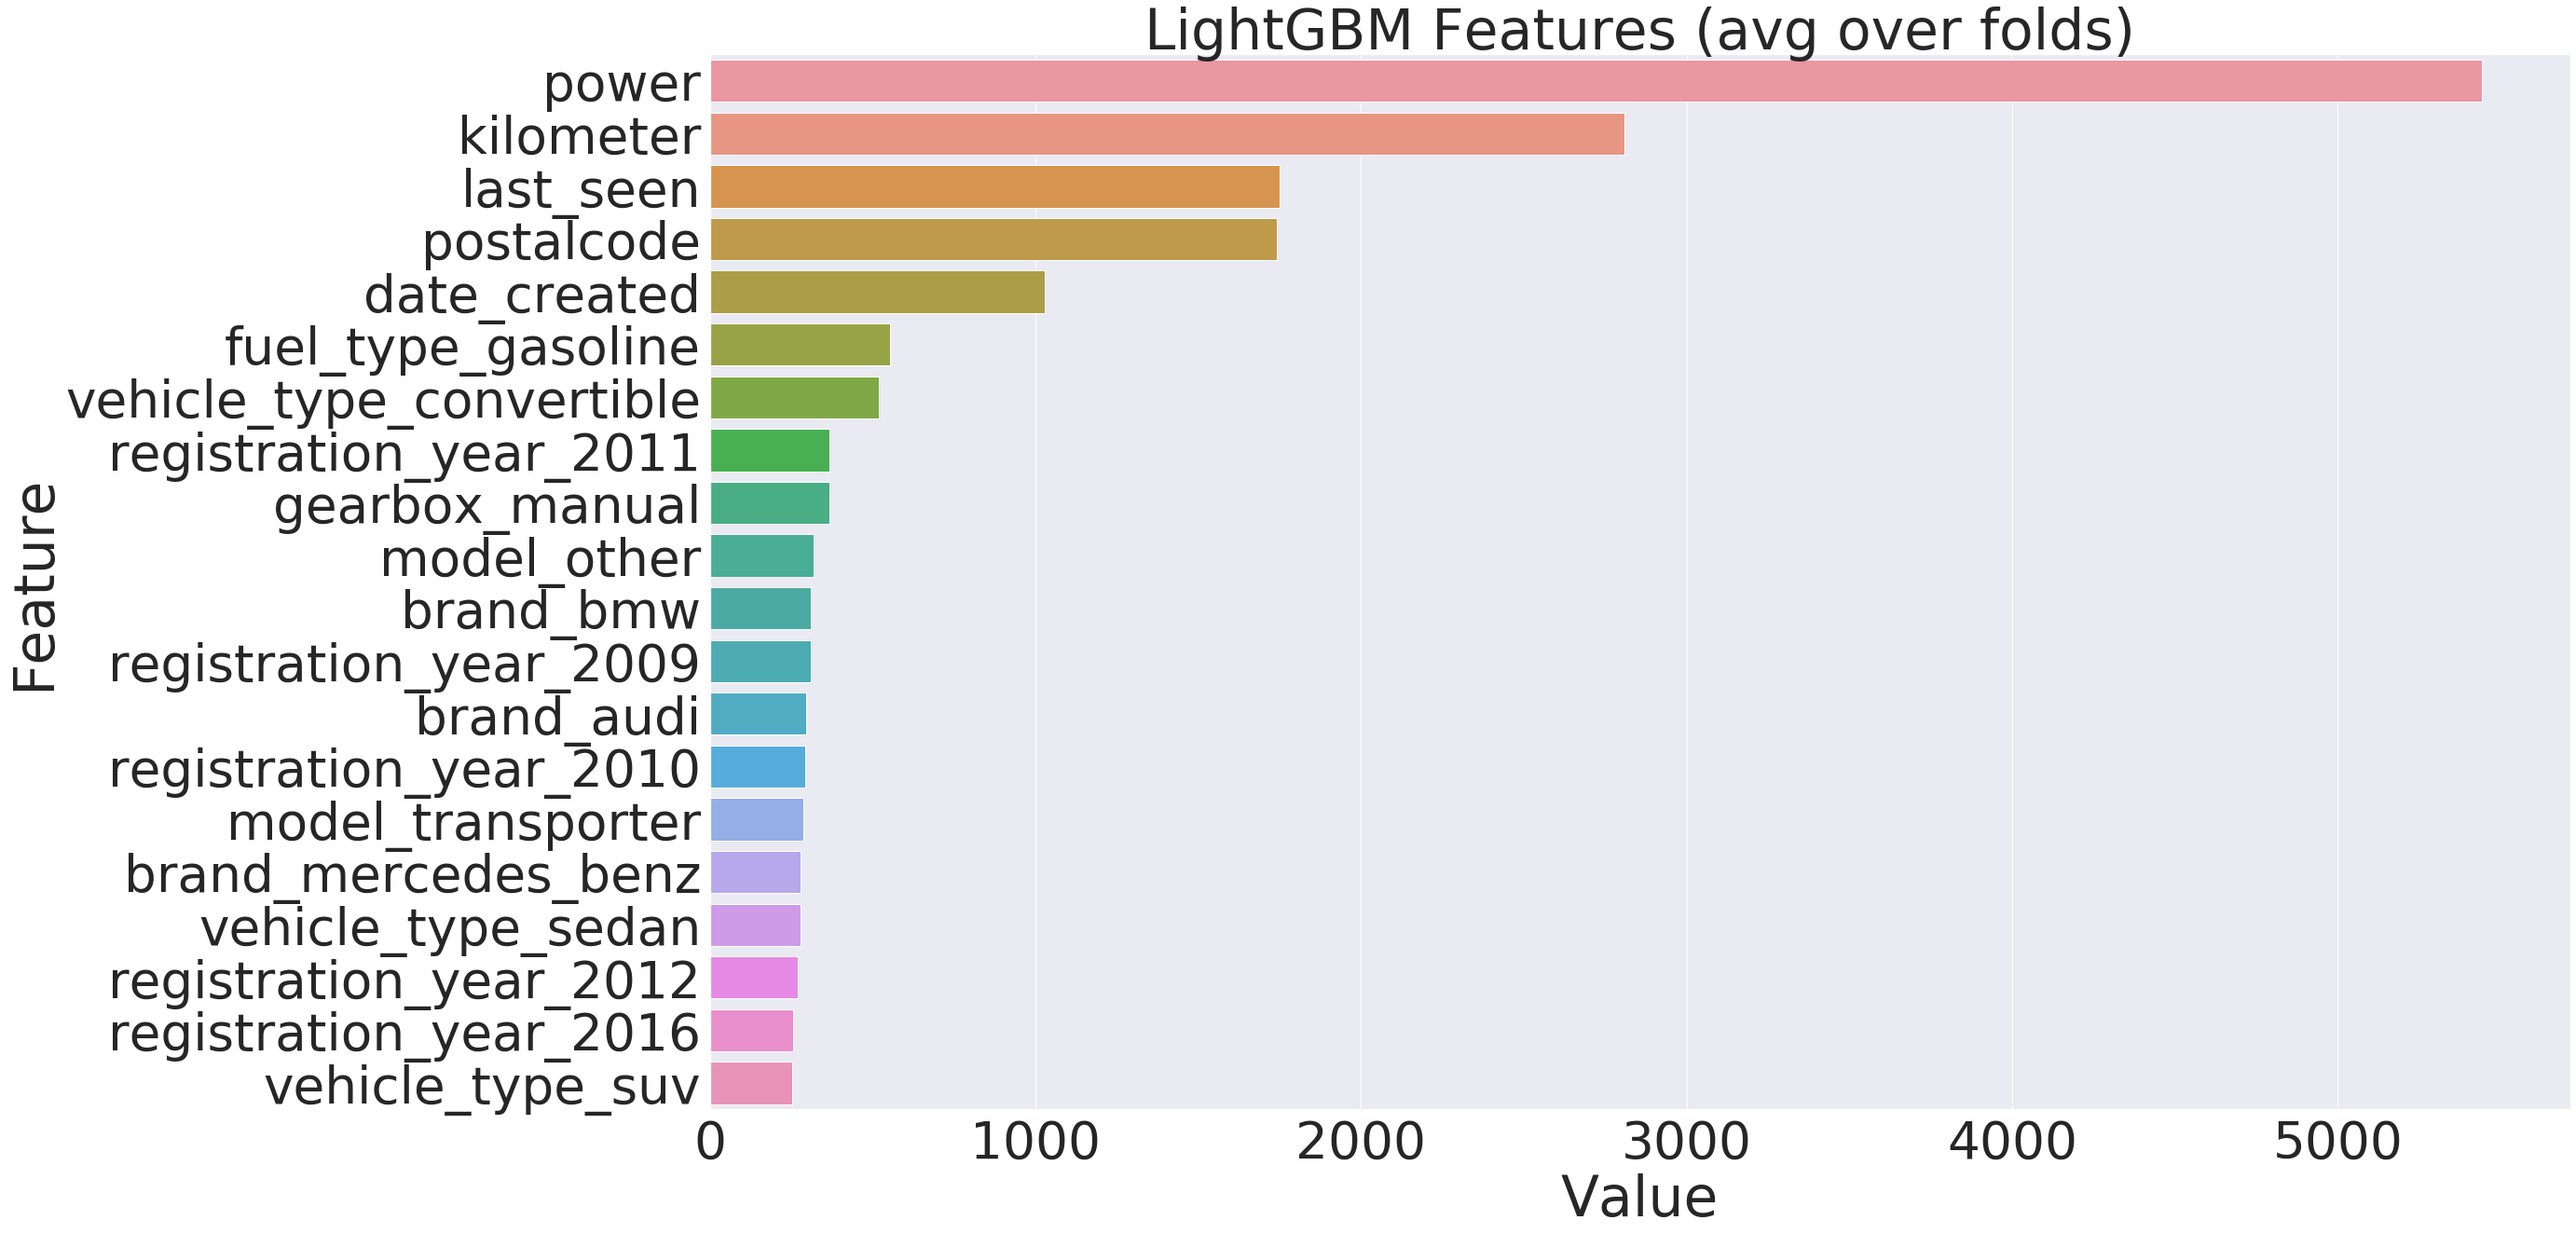

In [115]:
plotImp(gb_model, features_train)

<div style="border-radius: 15px; border: 1px solid grey; padding: 15px;">

Интересно...на песпективу можно было бы поиграть с весами, мощьность переоценена, как по мне.
    
</div>